In [1]:
import pandas as pd
import numpy as np
import os
import sys
import subprocess
sys.path.append('/Users/clu/git/3D_cardiac_GWAS/src')
from config import traits_dictionary, traits_group


import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
# set seaborn style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = ['Arial']

from bullseye import bullseye_plot, get_cmap_center

root_dir = '/Volumes/acasis/cardiac/48K/gwas_aha_t64/'

figures_dir = '/Users/clu/git/3D_cardiac_GWAS/SORTED/Figures/'

# Read and plot Exposure SBP/DBP, Outcome LV (adjusted with BP)
def read_mr_res(wd):
    basenameSBP='Exposure_SBP_ieu-b-38/40k_{trait}_{aha}_mr_SBP_res.txt'
    basenameDBP='Exposure_DBP_ieu-b-39/40k_{trait}_{aha}_mr_DBP_res.txt'
    # Read the results
    mr_res = pd.DataFrame(
        columns=pd.read_csv(os.path.join(wd, basenameSBP.format(trait="WT", aha='AHA_1')), sep="\t").columns
        )
    for trait in ['WT', 'Ecc', 'Err']:
        for i in range(1,17):
            mr_res = pd.concat([mr_res, pd.read_csv(os.path.join(wd, basenameSBP.format(trait=trait, aha=f'AHA_{i}')), sep="\t")])
            mr_res = pd.concat([mr_res, pd.read_csv(os.path.join(wd, basenameDBP.format(trait=trait, aha=f'AHA_{i}')), sep="\t")])
        mr_res = pd.concat([mr_res, pd.read_csv(os.path.join(wd, basenameSBP.format(trait=trait, aha='Global')), sep="\t")])        
        mr_res = pd.concat([mr_res, pd.read_csv(os.path.join(wd, basenameDBP.format(trait=trait, aha='Global')), sep="\t")])
        mr_res = mr_res.reset_index(drop=True)
        mr_res.drop(columns=['id.outcome'], inplace=True)
    # mr_res = mr_res[mr_res.method.isin(['MR Egger', 'Inverse variance weighted', 'Weighted median'])]
    # reverse the sign of the beta for Ecc
    mr_res.loc[mr_res['outcome'].str.contains('Ecc'), 'b'] = -mr_res.loc[mr_res['outcome'].str.contains('Ecc'), 'b']
    # assign exposure: if id.exposure is ieu-b-39, then exposure is DBP, else if it's ieu-b-38, exposure is SBP
    mr_res = mr_res.assign(
        cm = mr_res['id.exposure'].apply(lambda x: 'DBP' if x == 'ieu-b-39' else 'SBP'),
        fea = mr_res['outcome'].str.split('_').str[0],
        AHA = mr_res['outcome'].str.split('_').str[-1],
        # beta to odds ratio per SD increase
        # SBP: 1 SD = 20.7 mmHg, DBP: 1 SD = 11.3 mmHg
        or_ = np.exp(mr_res['b'] * (20.7 if mr_res['id.exposure'].str.contains('ieu-b-38').all() else 11.3)),
        or_ci_lower = np.exp((mr_res['b'] - 1.96 * mr_res['se']) * (20.7 if mr_res['id.exposure'].str.contains('ieu-b-38').all() else 11.3)),
        or_ci_upper = np.exp((mr_res['b'] + 1.96 * mr_res['se']) * (20.7 if mr_res['id.exposure'].str.contains('ieu-b-38').all() else 11.3))
        # or_ = np.exp(mr_res['b']),
        # or_ci_lower = np.exp(mr_res['b'] - 1.96 * mr_res['se']),
        # or_ci_upper = np.exp(mr_res['b'] + 1.96 * mr_res['se'])
    )
    mr_res = mr_res.assign(
        lower = mr_res['or_'] - mr_res['or_ci_lower'],
        upper = mr_res['or_ci_upper'] - mr_res['or_']
    )
    return mr_res

# plot OR and CI
def plot_IVW_OR_for_MRres_pval(mr_res):
    plt.rcParams['font.size'] = 14
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
    for i, cm in enumerate(['SBP', 'DBP']):
        for j, fea in enumerate(['WT', 'Ecc', 'Err']):
            toplot=mr_res[(mr_res.fea == fea) & (mr_res.cm == cm)]
            toplot = toplot[toplot['method']=='Inverse variance weighted']
            toplot=toplot.assign(ci=1.96*toplot['se'])
            # set toplot AHA as int
            # rename Global in AHA to 0
            toplot['AHA'] = toplot['AHA'].replace('Global', '0')
            toplot['AHA'] = toplot['AHA'].astype(int)
            # reverse order index in toplot
            # toplot = toplot.iloc[::-1]
            # plot these first to fix the yticks
            if cm == 'SBP':
                axes[j].errorbar(toplot['or_'], toplot['AHA']-0.2, xerr=np.array(toplot[['lower', 'upper']]).T, fmt='o', color='orange', ecolor='black', elinewidth=1.4, capsize=5)
            else:
                axes[j].errorbar(toplot['or_'], toplot['AHA']+0.2, xerr=np.array(toplot[['lower', 'upper']]).T, fmt='o', color='purple', ecolor='black', elinewidth=1.4, capsize=5)
            if fea =='Ecc':
                axes[j].set_title('Outcome: Circ Strain')
            elif fea == 'Err':
                axes[j].set_title('Outcome: Radial Strain')
            else:
                axes[j].set_title(f'Outcome: {fea}')
            axes[j].axvline(x=1, color='gray', linestyle='--')
            
            axes[j].set_xlabel('IVW MR OR per SD increase (95% CI)')
            axes[j].set_ylabel(' ')
            
            axes[j].set_yticks(toplot['AHA'])
            axes[j].set_yticklabels(toplot['AHA'].replace(0, 'Global'))
            axes[j].set_ylim(len(toplot['AHA'])+0.2, -1)
            # axes[j].set_xlim(-0.025, 0.025)
            # grid dashed
            axes[j].grid(True, linestyle='--')
            # x grid off
            axes[j].yaxis.grid(False)
            # set first ytick as bold
            axes[j].yaxis.get_major_ticks()[-1].label1.set_fontweight('bold')
            axes[j].axhspan(toplot['AHA'].iloc[0]-1.5, toplot['AHA'].iloc[0]-0.5, facecolor='lightgray', alpha=0.4)
            # add alternative color for y ticks as stripes of gray and white
            for i in range(1, len(toplot['AHA']), 2):
                # set the background color of the area
                axes[j].axhspan(toplot['AHA'].iloc[i]-0.5, toplot['AHA'].iloc[i]+0.5, facecolor='lightgray', alpha=0.2)
            # add * if pval < 0.05/16
            for i, row in toplot.iterrows():
                if row['pval'] < 0.05/16:
                    if cm == 'SBP':
                        axes[j].text(row['or_'], row['AHA']-0.25, '*', color='black', fontsize=18, fontweight='bold')
                    else:
                        # use bold font
                        axes[j].text(row['or_'], row['AHA']+0.25, '*', color='black', fontsize=18, fontweight='bold')
    plt.tight_layout()
    return fig

# mr_res = read_mr_res(root_dir+"/mr_2bp")
# fig = plot_IVW_OR_for_MRres(mr_res)
# fig.savefig(figures_dir + 'MR_exposure_BP_outcome_LVAHA_IVW-OR.pdf', bbox_inches='tight')

# # Read and plot Exposure SBP/DBP, Outcome LV (NOT adjusted with BP)
# mr_res_nobp = read_mr_res(root_dir+"/mr_nobp")
# fig = plot_IVW_OR_for_MRres_pval(mr_res_nobp)
# fig.savefig(figures_dir + 'MR_exposure_BP_outcome_LVAHA-noBP_IVW-OR.pdf', bbox_inches='tight')


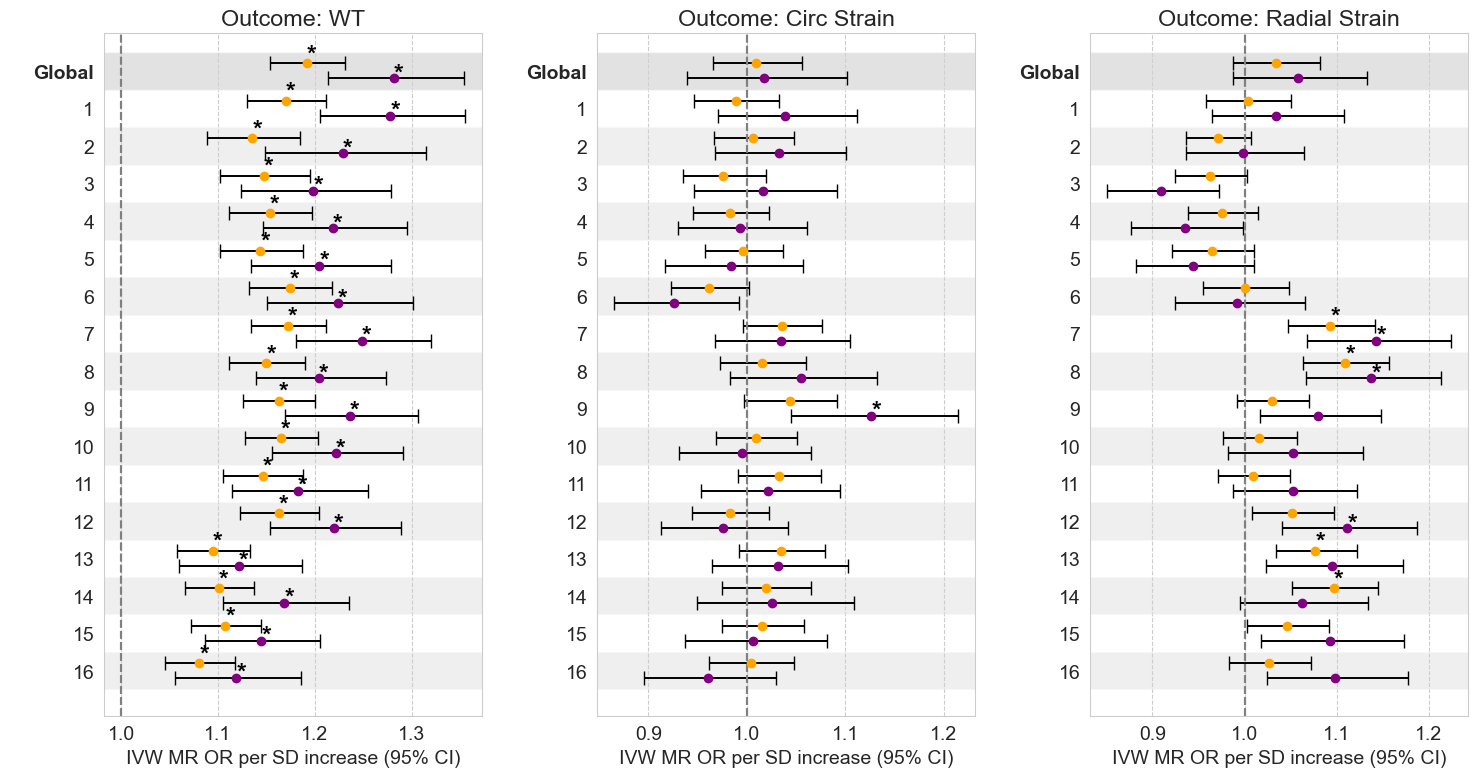

In [2]:
mr_res = read_mr_res(root_dir+"/mr_2bp")
fig = plot_IVW_OR_for_MRres_pval(mr_res)
fig.savefig(figures_dir + 'MR_exposure_BP_outcome_LVAHA_IVW-OR.pdf', bbox_inches='tight')

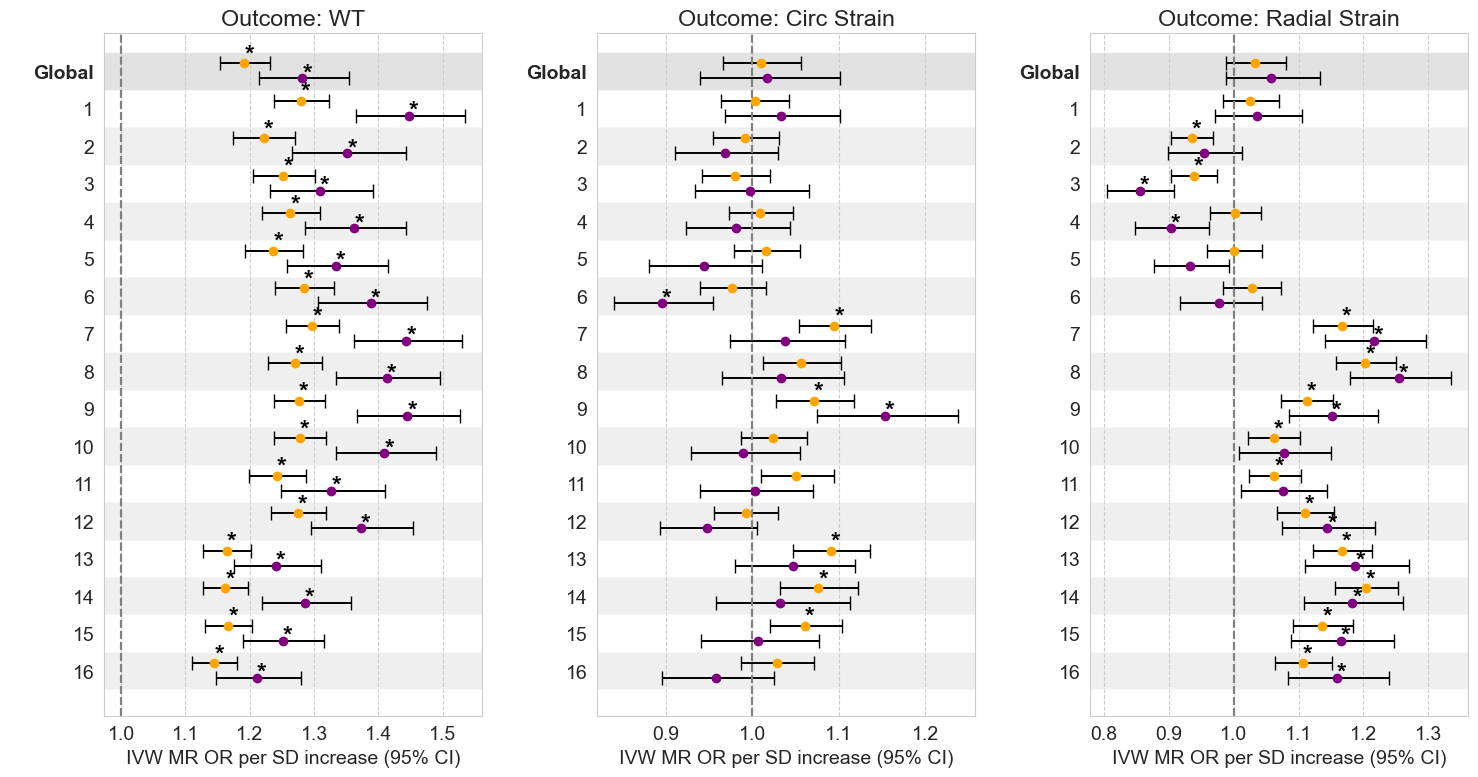

In [3]:
mr_res_nobp = read_mr_res(root_dir+"/mr_nobp")
fig = plot_IVW_OR_for_MRres_pval(mr_res_nobp)
fig.savefig(figures_dir + 'MR_exposure_BP_outcome_LVAHA-noBP_IVW-OR.pdf', bbox_inches='tight')

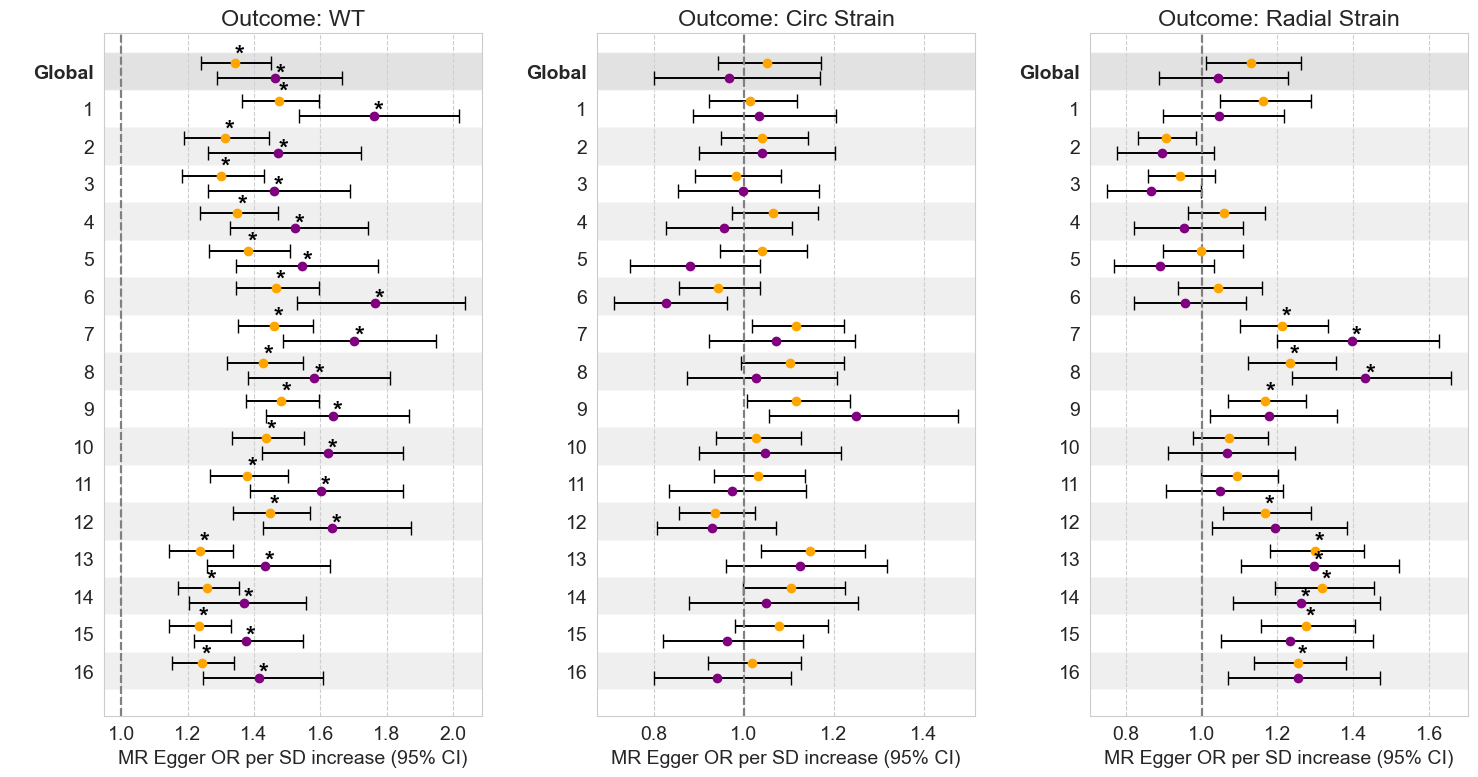

In [12]:
def plot_Egger_OR_for_MRres_pval(mr_res):
    plt.rcParams['font.size'] = 14
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
    for i, cm in enumerate(['SBP', 'DBP']):
        for j, fea in enumerate(['WT', 'Ecc', 'Err']):
            toplot=mr_res[(mr_res.fea == fea) & (mr_res.cm == cm)]
            toplot = toplot[toplot['method']=='MR Egger']
            toplot=toplot.assign(ci=1.96*toplot['se'])
            # set toplot AHA as int
            # rename Global in AHA to 0
            toplot['AHA'] = toplot['AHA'].replace('Global', '0')
            toplot['AHA'] = toplot['AHA'].astype(int)
            # reverse order index in toplot
            # toplot = toplot.iloc[::-1]
            # plot these first to fix the yticks
            if cm == 'SBP':
                axes[j].errorbar(toplot['or_'], toplot['AHA']-0.2, xerr=np.array(toplot[['lower', 'upper']]).T, fmt='o', color='orange', ecolor='black', elinewidth=1.4, capsize=5)
            else:
                axes[j].errorbar(toplot['or_'], toplot['AHA']+0.2, xerr=np.array(toplot[['lower', 'upper']]).T, fmt='o', color='purple', ecolor='black', elinewidth=1.4, capsize=5)
            if fea =='Ecc':
                axes[j].set_title('Outcome: Circ Strain')
            elif fea == 'Err':
                axes[j].set_title('Outcome: Radial Strain')
            else:
                axes[j].set_title(f'Outcome: {fea}')
            axes[j].axvline(x=1, color='gray', linestyle='--')
            
            axes[j].set_xlabel('MR Egger OR per SD increase (95% CI)')
            axes[j].set_ylabel(' ')
            
            axes[j].set_yticks(toplot['AHA'])
            axes[j].set_yticklabels(toplot['AHA'].replace(0, 'Global'))
            axes[j].set_ylim(len(toplot['AHA'])+0.2, -1)
            # axes[j].set_xlim(-0.025, 0.025)
            # grid dashed
            axes[j].grid(True, linestyle='--')
            # x grid off
            axes[j].yaxis.grid(False)
            # set first ytick as bold
            axes[j].yaxis.get_major_ticks()[-1].label1.set_fontweight('bold')
            axes[j].axhspan(toplot['AHA'].iloc[0]-1.5, toplot['AHA'].iloc[0]-0.5, facecolor='lightgray', alpha=0.4)
            # add alternative color for y ticks as stripes of gray and white
            for i in range(1, len(toplot['AHA']), 2):
                # set the background color of the area
                axes[j].axhspan(toplot['AHA'].iloc[i]-0.5, toplot['AHA'].iloc[i]+0.5, facecolor='lightgray', alpha=0.2)
            # add * if pval < 0.05/16
            for i, row in toplot.iterrows():
                if row['pval'] < 0.05/16:
                    if cm == 'SBP':
                        axes[j].text(row['or_'], row['AHA']-0.25, '*', color='black', fontsize=18, fontweight='bold')
                    else:
                        # use bold font
                        axes[j].text(row['or_'], row['AHA']+0.25, '*', color='black', fontsize=18, fontweight='bold')
    plt.tight_layout()
    return fig

fig = plot_Egger_OR_for_MRres_pval(mr_res_nobp)
fig.savefig(figures_dir + 'MR_exposure_BP_outcome_LVAHA-noBP_Egger-OR.pdf', bbox_inches='tight')

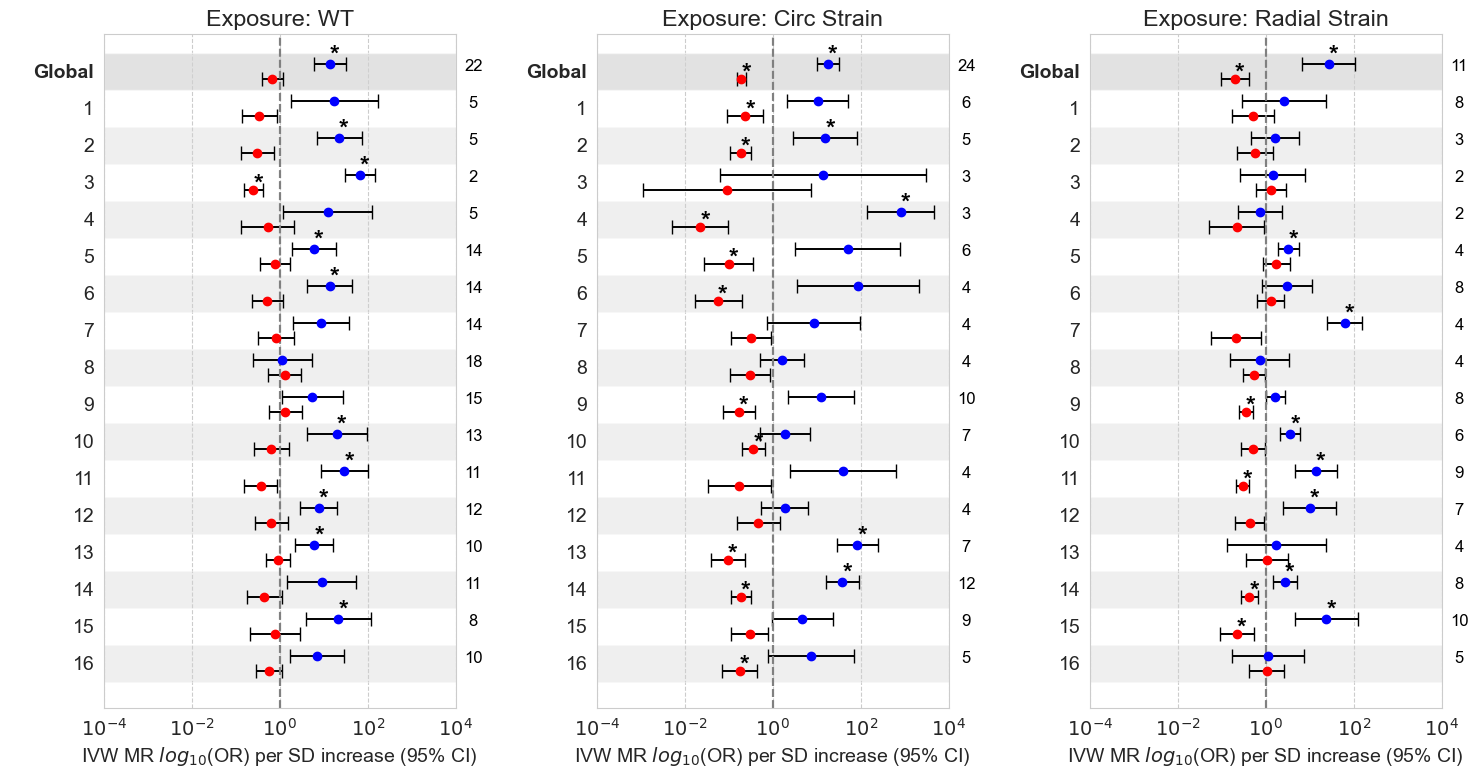

In [70]:
# Read and plot Exposure LV, Outcome HCM/DCM
def read_mr_res_LV_CM(wd):
    basename='Exposure_LV_Outcome_CM/40k_{trait}_{aha}_mr_{cm}_res.txt'
    # Read the results
    mr_res = pd.DataFrame(
        columns=pd.read_csv(os.path.join(wd, basename.format(trait="WT", aha='AHA_1', cm="HCM")), sep="\t").columns
        )
    for trait in ['WT', 'Ecc', 'Err']:
        for cm in ['HCM', 'DCM']:
            for i in range(1,17):
                mr_res = pd.concat([mr_res, pd.read_csv(os.path.join(wd, basename.format(trait=trait, aha=f'AHA_{i}', cm=cm)), sep="\t")])
            mr_res = pd.concat([mr_res, pd.read_csv(os.path.join(wd, basename.format(trait=trait, aha='Global_AHA_16', cm=cm)), sep="\t")])        
        mr_res = mr_res.reset_index(drop=True)
        mr_res.drop(columns=['id.outcome'], inplace=True)
    # mr_res = mr_res[mr_res.method.isin(['MR Egger', 'Inverse variance weighted', 'Weighted median'])]
    # reverse the sign of the beta for Ecc
    mr_res.loc[mr_res['exposure'].str.contains('Ecc'), 'b'] = -mr_res.loc[mr_res['exposure'].str.contains('Ecc'), 'b']
    # assign exposure: if id.exposure is ieu-b-39, then exposure is DBP, else if it's ieu-b-38, exposure is SBP
    mr_res = mr_res.assign(
        fea = mr_res['exposure'].str.split('_').str[0],
        AHA = mr_res['exposure'].str.split('_').str[-1],
        or_ = np.exp(mr_res['b']),
        or_ci_lower = np.exp(mr_res['b'] - 1.96 * mr_res['se']),
        or_ci_upper = np.exp(mr_res['b'] + 1.96 * mr_res['se'])
    )
    # replace Global_AHA_16 with Global
    mr_res.loc[mr_res['exposure'].str.contains('Global_AHA_16'), 'AHA'] = 'Global'
    mr_res = mr_res.assign(
        lower = np.log10(mr_res['or_']) - np.log10(mr_res['or_ci_lower']),
        upper = np.log10(mr_res['or_ci_upper']) - np.log10(mr_res['or_'])
    )
    return mr_res

# plot OR and CI
def plot_IVW_OR_for_MRres_LV_CM(mr_res):
    plt.rcParams['font.size'] = 14
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
    for i, cm in enumerate(['HCM', 'DCM']):
        for j, fea in enumerate(['WT', 'Ecc', 'Err']):
            toplot=mr_res[(mr_res.fea == fea) & (mr_res.outcome == cm)]
            toplot = toplot[toplot['method']=='Inverse variance weighted']
            toplot=toplot.assign(ci=1.96*toplot['se'])
            # set toplot AHA as int
            # rename Global in AHA to 0
            toplot['AHA'] = toplot['AHA'].replace('Global', '0')
            toplot['AHA'] = toplot['AHA'].astype(int)
            # reverse order index in toplot
            # toplot = toplot.iloc[::-1]
            # plot these first to fix the yticks
            if cm == 'HCM':
                axes[j].errorbar(toplot['or_'], toplot['AHA']-0.2, xerr=np.array(toplot[['lower', 'upper']]).T, fmt='o', color='blue', ecolor='black', elinewidth=1.4, capsize=5)
            else:
                axes[j].errorbar(toplot['or_'], toplot['AHA']+0.2, xerr=np.array(toplot[['lower', 'upper']]).T, fmt='o', color='red', ecolor='black', elinewidth=1.4, capsize=5)
            if fea =='Ecc':
                axes[j].set_title('Exposure: Circ Strain')
            elif fea == 'Err':
                axes[j].set_title('Exposure: Radial Strain')
            else:
                axes[j].set_title(f'Exposure: {fea}')
            axes[j].axvline(x=1, color='gray', linestyle='--')
            
            axes[j].set_xlabel('IVW MR OR per SD increase (95% CI)')
            axes[j].set_ylabel(' ')
            axes[j].set_yticks(toplot['AHA'])
            axes[j].set_yticklabels(toplot['AHA'].replace(0, 'Global'))
            axes[j].set_ylim(len(toplot['AHA'])+0.2, -1)
            # axes[j].set_xlim(-0.025, 0.025)
            # grid dashed
            axes[j].grid(True, linestyle='--')
            # x grid off
            axes[j].yaxis.grid(False)
            # set first ytick as bold
            axes[j].yaxis.get_major_ticks()[-1].label1.set_fontweight('bold')
            axes[j].axhspan(toplot['AHA'].iloc[0]-1.5, toplot['AHA'].iloc[0]-0.5, facecolor='lightgray', alpha=0.4)
            # add alternative color for y ticks as stripes of gray and white
            for i in range(1, len(toplot['AHA']), 2):
                # set the background color of the area
                axes[j].axhspan(toplot['AHA'].iloc[i]-0.5, toplot['AHA'].iloc[i]+0.5, facecolor='lightgray', alpha=0.2)
            # add * if pval < 0.05/16
            for i, row in toplot.iterrows():
                if row['pval'] < 0.05/16:
                    if cm == 'HCM':
                        axes[j].text(row['or_'], row['AHA']-0.25, '*', color='black', fontsize=18, fontweight='bold')
                    else:
                        # use bold font
                        axes[j].text(row['or_'], row['AHA']+0.25, '*', color='black', fontsize=18, fontweight='bold')
    plt.tight_layout()
    return fig

# plot OR and CI in log10 scale
def plot_IVW_OR_for_MRres_LV_CM_log10(mr_res):
    plt.rcParams['font.size'] = 14
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 8))
    for i, cm in enumerate(['HCM', 'DCM']):
        for j, fea in enumerate(['WT', 'Ecc', 'Err']):
            toplot=mr_res[(mr_res.fea == fea) & (mr_res.outcome == cm)]
            toplot = toplot[toplot['method']=='Inverse variance weighted']
            toplot=toplot.assign(ci=1.96*toplot['se'])
            # set toplot AHA as int
            # rename Global in AHA to 0
            toplot['AHA'] = toplot['AHA'].replace('Global', '0')
            toplot['AHA'] = toplot['AHA'].astype(int)
            # reverse order index in toplot
            # toplot = toplot.iloc[::-1]
            # plot these first to fix the yticks
            if cm == 'HCM':
                axes[j].errorbar(np.log10(toplot['or_']), toplot['AHA']-0.2, xerr=np.array(toplot[['lower', 'upper']]).T, fmt='o', color='blue', ecolor='black', elinewidth=1.4, capsize=5)
            else:
                axes[j].errorbar(np.log10(toplot['or_']), toplot['AHA']+0.2, xerr=np.array(toplot[['lower', 'upper']]).T, fmt='o', color='red', ecolor='black', elinewidth=1.4, capsize=5)
            if fea =='Ecc':
                axes[j].set_title('Exposure: Circ Strain')
            elif fea == 'Err':
                axes[j].set_title('Exposure: Radial Strain')
            else:
                axes[j].set_title(f'Exposure: {fea}')
            axes[j].axvline(x=0, color='gray', linestyle='--')
            
            axes[j].set_xlabel('IVW MR $log_{10}$(OR) per SD increase (95% CI)')
            axes[j].set_ylabel(' ')
            axes[j].set_yticks(toplot['AHA'])
            axes[j].set_yticklabels(toplot['AHA'].replace(0, 'Global'))
            axes[j].set_ylim(len(toplot['AHA'])+0.2, -1)
            axes[j].set_xlim(-4,4)
            # set x ticks as 10^x
            axes[j].set_xticks([-4,-2,0,2,4])
            axes[j].set_xticklabels([f'$10^{{{x}}}$' for x in [-4,-2,0,2,4]])
            # grid dashed
            axes[j].grid(True, linestyle='--')
            # x grid off
            axes[j].yaxis.grid(False)
            # set first ytick as bold
            axes[j].yaxis.get_major_ticks()[-1].label1.set_fontweight('bold')
            axes[j].axhspan(toplot['AHA'].iloc[0]-1.5, toplot['AHA'].iloc[0]-0.5, facecolor='lightgray', alpha=0.4)
            # add alternative color for y ticks as stripes of gray and white
            for i in range(1, len(toplot['AHA']), 2):
                # set the background color of the area
                axes[j].axhspan(toplot['AHA'].iloc[i]-0.5, toplot['AHA'].iloc[i]+0.5, facecolor='lightgray', alpha=0.2)
            # add * if pval < 0.05/16
            for i, row in toplot.iterrows():
                if row['pval'] < 0.05/16:
                    if cm == 'HCM':
                        axes[j].text(np.log10(row['or_']), row['AHA']-0.25, '*', color='black', fontsize=18, fontweight='bold')
                    else:
                        # use bold font
                        axes[j].text(np.log10(row['or_']), row['AHA']+0.25, '*', color='black', fontsize=18, fontweight='bold')
            # label number of instruments for each row, which is nsnp column
            for i, row in toplot.iterrows():
                if cm == 'HCM':
                    axes[j].text(4.4, row['AHA'], row['nsnp'], color='black', fontsize=12, ha='center')
                # else:
                #     axes[j].text(4.9, row['AHA'], row['nsnp'], color='darkred', fontsize=12, ha='center')
                

    plt.tight_layout()
    return fig

# mr_res_LV_CM = read_mr_res_LV_CM(root_dir+"/mr_nobp/")
fig = plot_IVW_OR_for_MRres_LV_CM_log10(mr_res_LV_CM)
fig.savefig(figures_dir + 'MR_exposure_LV_outcome_CM_IVW-OR.pdf', bbox_inches='tight')